# Lesson 15.1 学习率调度基本概念与手动实现方法

&emsp;&emsp;从本节开始，我们将介绍深度学习中学习率优化方法。学习率作为模型优化的重要超参数，在此前的学习中，我们已经看到了学习率的调整对模型训练在诸多方面的显著影响。这里我们先简单回顾此前遇到的学习率调整的场景：

- 缓解Dead ReLU Problem      
&emsp;&emsp;在ReLU激活函数叠加的神经网络中，由于ReLU本身负值归零的特性，可能会出现Dead ReLU Problem，根据Lesson 13.4的实验结果，我们可以通过减小学习率来降低模型落入活性失效陷进的概率。不过降低学习率也代表模型收敛速度更慢；

- 提升模型表现      
&emsp;&emsp;同时，学习率调整的也将显著影响模型性能。根据Lesson 14中的实验结果可知，在学习率绝对数值的调整过程中，学习率对模型性能的影响整体呈现U型（以准确率评估指标时是倒U型）特征，即学习率过大或者过小都不好，学习过大可能会导致模型无法穿越狭窄的通道最终抵达最小值点，而学习率太小则容易在最小值点附近停止收敛，因此在进行模型训练时，我们需要找到一个适中的准确率取值（如Lesson 14.3中的0.005）。

&emsp;&emsp;整体来看，如果模型学习率设置太大，虽然前期收敛速度较快，但容易出现收敛过程不稳定、收敛结果不佳、或者神经元活性失效等问题；而如果学习率设置太小，虽然收敛过程将相对平稳，并且能够有效规避神经元活性坏死的问题，但容易出现收敛速度慢、收敛结果不佳等问题。为了深入理解该问题，同时也为了为后续实验储备对比数据，首先，我们可以通过设计实验来观测不同超参数取值对模型收敛速度、收敛结果影响。

### 一、学习率对模型训练影响

&emsp;&emsp;仍然利用Lesson 14中所定义的模型类和数据，通过设置不同学习率，来观察学习率对模型收敛速度和收敛结果两方面影响情况。

In [1]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

# 自定义模块
from torchLearning import *

# 导入以下包从而使得可以在jupyter中的一个cell输出多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1, 3, 1, 2], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels, batch_size=50)

In [ ]:
# 设置随机数种子
torch.manual_seed(24)  

# 关键参数
num_epochs = 20

# 实例化模型  
tanh_model1 = net_class2(act_fun = torch.tanh, in_features=5, BN_model='pre')
tanh_model2 = net_class2(act_fun = torch.tanh, in_features=5, BN_model='pre')
tanh_model3 = net_class2(act_fun = torch.tanh, in_features=5, BN_model='pre')
tanh_model4 = net_class2(act_fun = torch.tanh, in_features=5, BN_model='pre')

In [ ]:
# tanh_model进行模型训练
train_l1, test_l1 = model_train_test(tanh_model1, 
                                     train_loader,
                                     test_loader,
                                     num_epochs = num_epochs, 
                                     criterion = nn.MSELoss(), 
                                     optimizer = optim.SGD, 
                                     lr = 0.03, 
                                     cla = False, 
                                     eva = mse_cal)

train_l2, test_l2 = model_train_test(tanh_model2, 
                                     train_loader,
                                     test_loader,
                                     num_epochs = num_epochs, 
                                     criterion = nn.MSELoss(), 
                                     optimizer = optim.SGD, 
                                     lr = 0.01, 
                                     cla = False, 
                                     eva = mse_cal)

train_l3, test_l3 = model_train_test(tanh_model3, 
                                     train_loader,
                                     test_loader,
                                     num_epochs = num_epochs, 
                                     criterion = nn.MSELoss(), 
                                     optimizer = optim.SGD, 
                                     lr = 0.005, 
                                     cla = False, 
                                     eva = mse_cal)

train_l4, test_l4 = model_train_test(tanh_model4, 
                                     train_loader,
                                     test_loader,
                                     num_epochs = num_epochs, 
                                     criterion = nn.MSELoss(), 
                                     optimizer = optim.SGD, 
                                     lr = 0.001, 
                                     cla = False, 
                                     eva = mse_cal)

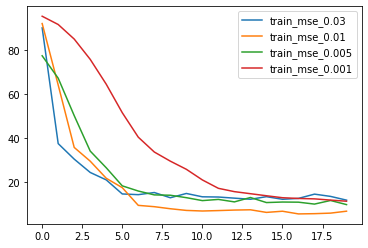

In [ ]:
plt.plot(list(range(num_epochs)), train_l1, label='train_mse_0.03')
plt.plot(list(range(num_epochs)), train_l2, label='train_mse_0.01')
plt.plot(list(range(num_epochs)), train_l3, label='train_mse_0.005')
plt.plot(list(range(num_epochs)), train_l4, label='train_mse_0.001')
plt.legend(loc = 1)

&emsp;&emsp;由此我们能够清楚的看到，学习率较大的模型收敛速度较快，但效果却不一定最好。而学习率非常小的模型不仅收敛速度较慢，并且效果也不尽如人意。对于tanh2来说，在当前数据集上，学习率为0.001时表现较好。

&emsp;&emsp;不过，值得注意的是，尽管学习率的调整会对模型训练造成很大的影响，但在进行学习率优化的时候一般不会采用Lesson 14.3中同时训练多组学习率采用不同取值的模型来对比选择最佳学习率的方法。在实际生产生活中，训练一个模型已经是非常耗费时间的了，为了一个超参数同时训练多组模型并不划算。而要通过学习率数值调整来让模型“又好又快”的收敛，就需要采用一种名为学习率调度的优化算法。

## 二、学习率调度基本概念与手动实现方法

### 1.模型调度基本概念

&emsp;&emsp;既然我们无法通过训练多组模型来寻找最优学习率，那么一个最基本的想法，就是让学习率伴随模型训练过程动态调整。并且，根据上述实验结果我们也不难发现，一个比较好的学习率动态调整策略是，先让学习率取得较大数值，从而能够让模型在最开始能够以较快的速度收敛；然后在经过一段时间迭代之后，将学习率调小，从而能够让收敛过程穿过损失函数的“隘口”，抵达更小的解。

&emsp;&emsp;这样的一个学习率调整的策略，也被称为学习率调度（Learning rate scheduler）。

> 注：此处学习率的调整和一般的超参数调整不太一样。一般来说，模型的超参数调整是需要找出一个有助于模型提升效果的确定性的数值，比如模型层数、激活函数、归一化方法选取等，而一旦超参数数值确定，无论是训练过程还是测试过程都将以该参数的取值为准。但学习率参数本质上并不是一个影响模型结构的参数，而是辅助训练过程的参数，更准确的来说，是辅助模型各线性层（目前为止）参数取得最优解的参数。因此，学习率确实是否是确定的值其实并不重要，学习率取值可以随着迭代过程不断变化，只要这样的一个动态变化的过程最终能够让模型“又好又快”的收敛、即让各线性层参数以较快速度收敛至最小值。

### 2.手动实现学习率调度

#### 2.1 本地实现方法

&emsp;&emsp;而要在PyTorch中实现学习率的动态调整，首先我们能够想到的是在fit过程手动调整学习率，例如，第一次fit设置2轮epochs、lr设置为0.03，第二次fit设置2轮epochs、lr设置0.01等等依此类推。我们可以借助Python中的input函数来手动实现学习率伴随迭代epoch次数的动态调整，具体操作方法如下：

- 实例化模型

In [3]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_model='pre')

- 更新fit函数

&emsp;&emsp;接下来我们对fit函数进行更新，在原有fit函数基础上加上每一轮迭代后模型评估结果的记录功能。

In [4]:
def fit_rec(net, 
            criterion, 
            optimizer, 
            train_data,
            test_data,
            epochs = 3, 
            cla = False, 
            eva = mse_cal):
    """模型训练函数（记录每一次遍历后模型评估指标）
    
    :param net：待训练的模型 
    :param criterion: 损失函数
    :param optimizer：优化算法
    :param train_data：训练数据
    :param test_data: 测试数据 
    :param epochs: 遍历数据次数
    :param cla: 是否是分类问题
    :param eva: 模型评估方法
    :return：模型评估结果
    """
    train_l = []
    test_l = []
    for epoch  in range(epochs):
        net.train()
        for X, y in train_data:
            if cla == True:
                y = y.flatten().long()          # 如果是分类问题，需要对y进行整数转化
            yhat = net.forward(X)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        net.eval()
        train_l.append(eva(train_data, net).detach())
        test_l.append(eva(test_data, net).detach())
    return train_l, test_l

- 测试函数性能

In [5]:
fit_rec(net = tanh_model, 
        criterion = nn.MSELoss(), 
        optimizer = optim.SGD(tanh_model.parameters(), lr = 0.03), 
        train_data = train_loader,
        test_data = test_loader,
        epochs = 3, 
        cla = False, 
        eva = mse_cal)

([tensor(37.9793), tensor(32.4801), tensor(30.2007)],
 [tensor(37.7321), tensor(33.3702), tensor(32.1592)])

能够顺利导出模型MSE计算结果，说明函数创建成功。另外，该函数也需要写入torchLearning.py中。

- 手动动态调整过程

&emsp;&emsp;接下来，我们尝试借助Python中的input函数功能，来执行手动动态调整模型训练过程中的学习率。

&emsp;&emsp;所谓手动调整学习率，指的是可以在自定义的训练间隔中灵活调整模型学习率，而要将手动输入的数值作为模型当前阶段训练的参数，就需要使用input函数。Python中的input函数通过提供用户可交互的输入窗口来捕捉用户的即时输入，并将其转化为字符串形式传入当前操作空间中。

In [6]:
# 输入1，则a为字符串1
a = input()

1


In [ ]:
a

'1'

In [ ]:
# 在外侧嵌套转化为浮点数的函数，则可将输入结果转化为浮点型对象
a = float(input())

 1


In [ ]:
a

1.0

据此，我们可以设计一个简单的计算流程，根据手动输入结果灵活控制每一次迭代的epochs以及对应的学习率数值。并且将每一轮循环结果记录在一个列表中。

In [7]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_model='pre')

In [8]:
input("Do you want to continue the iteration? [y/n]") 

Do you want to continue the iteration? [y/n]Y


'Y'

In [ ]:
l1 = [1, 2, 3]
l2 = [2, 3, 4]

In [ ]:
l1.extend(l2)

In [ ]:
l1

[1, 2, 3, 2, 3, 4]

In [ ]:
l1.append(l2)

In [ ]:
l1

[1, 2, 3, 2, 3, 4, [2, 3, 4]]

In [10]:
# 创建用于保存记录结果的空列表容器
train_mse = []
test_mse = []

# 创建可以捕捉手动输入数据的模型训练流程
while input("Do you want to continue the iteration? [y/n]") == "y":    # 询问是否继续迭代
    epochs = int(input("Number of epochs:"))                           # 下一轮迭代遍历几次数据
    lr = float(input("Update learning rate："))                        # 设置下一轮迭代的学习率
    train_l, test_l = fit_rec(net = tanh_model, 
                              criterion = nn.MSELoss(), 
                              optimizer = optim.SGD(tanh_model.parameters(), lr = lr), 
                              train_data = train_loader,
                              test_data = test_loader,
                              epochs = epochs, 
                              cla = False, 
                              eva = mse_cal)
    train_mse.extend(train_l)
    test_mse.extend(test_l)

Do you want to continue the iteration? [y/n]y
Number of epochs:10
Update learning rate：0.03
Do you want to continue the iteration? [y/n]y
Number of epochs:10
Update learning rate：0.01
Do you want to continue the iteration? [y/n]n


查看模型运行结果

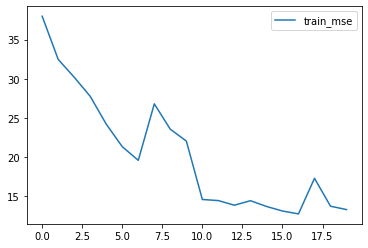

In [11]:
plt.plot(train_mse, label='train_mse')
plt.legend(loc = 1)

同时，我们可以让模型以0.03作为学习率迭代60个epochs，对比模型训练效果

In [12]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_model='pre')

In [13]:
# 创建用于保存记录结果的空列表容器
train_msel = []
test_msel = []

# 创建可以捕捉手动输入数据的模型训练流程
while input("Do you want to continue the iteration? [y/n]") == "y":    # 询问是否继续迭代
    epochs = int(input("Number of epochs:"))                           # 下一轮迭代遍历几次数据
    lr = float(input("Update learning rate："))                        # 设置下一轮迭代的学习率
    train_l, test_l = fit_rec(net = tanh_model, 
                              criterion = nn.MSELoss(), 
                              optimizer = optim.SGD(tanh_model.parameters(), lr = lr), 
                              train_data = train_loader,
                              test_data = test_loader,
                              epochs = epochs, 
                              cla = False, 
                              eva = mse_cal)
    train_msel.extend(train_l)
    test_msel.extend(test_l)

Do you want to continue the iteration? [y/n]y
Number of epochs:20
Update learning rate：0.03
Do you want to continue the iteration? [y/n]n


Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

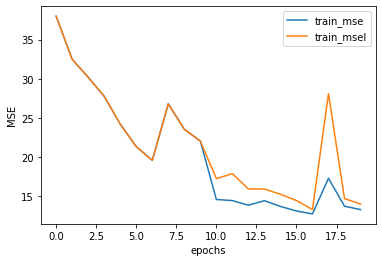

In [14]:
plt.plot(train_mse, label='train_mse')
plt.plot(train_msel, label='train_msel')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

能够看出，手动调整模型学习率的第一个模型在最终模型表现上比第二个模型更好，在同样遍历了60次的情况下，模型一能够收敛至一个更小的MSE。

&emsp;&emsp;此外，我们再令模型一直以学习率为0.01进行训练，测试模型最终效果。

In [15]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_model='pre')

In [16]:
# 创建用于保存记录结果的空列表容器
train_mses = []
test_mses = []

# 创建可以捕捉手动输入数据的模型训练流程
while input("Do you want to continue the iteration? [y/n]") == "y":    # 询问是否继续迭代
    epochs = int(input("Number of epochs:"))                           # 下一轮迭代遍历几次数据
    lr = float(input("Update learning rate："))                        # 设置下一轮迭代的学习率
    train_l, test_l = fit_rec(net = tanh_model, 
                              criterion = nn.MSELoss(), 
                              optimizer = optim.SGD(tanh_model.parameters(), lr = lr), 
                              train_data = train_loader,
                              test_data = test_loader,
                              epochs = epochs, 
                              cla = False, 
                              eva = mse_cal)
    train_mses.extend(train_l)
    test_mses.extend(test_l)

Do you want to continue the iteration? [y/n]y
Number of epochs:20
Update learning rate：0.01
Do you want to continue the iteration? [y/n]n


Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

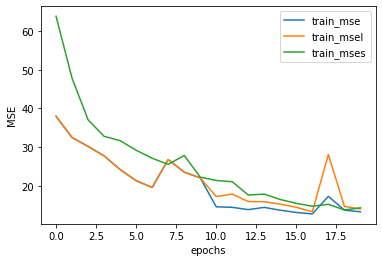

In [18]:
plt.plot(train_mse, label='train_mse')
plt.plot(train_msel, label='train_msel' )
plt.plot(train_mses, label='train_mses')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

我们能够发现，第一个模型收敛速度明显快于第二个模型，据此也能说明手动调整模型学习率的有效性。

#### 2.2 配合tensorboard实现方法

&emsp;&emsp;当然，上述过程中，由于我们只能当模型全部训练完毕之后才能进行绘图，因此上述其实存在一个实践层面的问题——如果我们无法得知当前阶段模型运行情况，我们又如何能够选择适当策略对模型进行调整。要解决该问题，就必须借助此前介绍的tensorboard工具进行即时的数据记录与呈现。

&emsp;&emsp;在Python中，尤其是在jupyter中，代码只能逐个cell运行，如果input对应的cell没有执行完毕，则无法进行后续绘图操作。但tensorboard中writer对象却能够即时记录模型中间结果，并且同步呈现在tensorboard的操作面板上。借此功能，我们便能将在某个cell尚未运行结束之前看到当前阶段的运行结果。要完成该过程，则需要在此前代码基础之上进行修改。

需要说明的是，这里将用到for循环的多变量同步循环函数zip，也就是多个临时变量同时遍历多个有序对象。

In [ ]:
l1 = list(range(10))
l1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
l1[3:5]

[3, 4]

In [ ]:
l2 = list(range(1, 3))
l2

[1, 2]

In [ ]:
for i, j in zip(l2, l1[3:5]):
    print(i, j)

1 3
2 4


具体修改后代码如下：

In [ ]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model = net_class2(act_fun= torch.tanh, in_features=5, BN_model='pre')

In [ ]:
# 实例化writer对象
writer = SummaryWriter(log_dir='l3')

# 创建空列表容器
train_mse = []
test_mse = []

# 创建总遍历次数计数器
num_epochs = 0

提前打开tensorboard服务，在命令行中输入

```shell
F:
cd "F:\Code File\PyTorch实战\"
tensorboard --logdir="l3"
```

待服务启动完成后，即可执行下述代码：

In [ ]:
while input("Do you want to continue the iteration? [y/n]") == "y":
    epochs = int(input("Number of epochs:"))
    lr = float(input("Update learning rate："))
    train_l, test_l = fit_rec(net = tanh_model, 
                              criterion = nn.MSELoss(), 
                              optimizer = optim.SGD(tanh_model.parameters(), lr = lr), 
                              train_data = train_loader,
                              test_data = test_loader,
                              epochs = epochs, 
                              cla = False, 
                              eva = mse_cal)
    train_mse.extend(train_l)
    test_mse.extend(test_l)
    for i, j in zip(list(range(num_epochs, num_epochs+epochs)), train_mse[num_epochs: num_epochs+epochs]):
        writer.add_scalar('train_mse', j, i)
    for i, j in zip(list(range(num_epochs, num_epochs+epochs)), test_mse[num_epochs: num_epochs+epochs]):
        writer.add_scalar('test_mse', j, i)
    num_epochs += epochs

Do you want to continue the iteration? [y/n] y
Number of epochs: 30
Update learning rate： 0.03
Do you want to continue the iteration? [y/n] y
Number of epochs: 30
Update learning rate： 0.01
Do you want to continue the iteration? [y/n] n


> 注，上述代码中train_mse[num_epochs: num_epochs+epochs]就是本次循环中的train_l，代码中可以用train_l代替。

当我们执行完第一阶段的30次遍历之后，我们即可打开浏览器输入`localhost:6006`查看当前记录的模型MSE情况。

<center><img src="https://i.loli.net/2021/03/29/mEMeOSqluXyQxfC.jpg" alt="70" style="zoom:30%;" />

然后再执行第二阶段的30次遍历数据的训练，执行完成后停止训练，在tensorboard面板中查看前两轮整体训练情况

<center><img src="https://i.loli.net/2021/03/29/2Up1F4wSqiHsNB9.jpg" alt="71" style="zoom:30%;" />

值得注意的是，当我们在使用add_scalar进行数据记录时，绘制折线图的横纵坐标都是必须的，如果缺失了横坐标，tensorboard中图像绘制的最终结果将呈现一条竖线。

In [ ]:
for i in range(10):
    writer.add_scalar('i',i)

<center><img src="https://i.loli.net/2021/03/29/HU8a2f36JTFGQD5.jpg" alt="73" style="zoom:30%;" />

并且，为了保证每一轮结果“横坐标”的唯一性，我们需要按照上述方法设置迭代计数器。

&emsp;&emsp;至此，我们通过借助tensorboard动态记录的特性，完成了模型训练过程中间结果的查看。当然，由于我们是在循环外设置的遍历次数计数器，因此哪怕上一次循环已经停止，接下来我们仍然可以继续在上一次停止时计数器的数值基础上再开启新的一轮循环。

In [ ]:
num_epochs          # 上一轮循环截止时总共遍历多少次数据

60

我们再遍历30次数据，并设置学习率为0.005进行模型训练，测试代码性能与模型效果

In [ ]:
while input("Do you want to continue the iteration? [y/n]") == "y":
    epochs = int(input("Number of epochs:"))
    lr = float(input("Update learning rate："))
    train_l, test_l = fit_rec(net = tanh_model, 
                              criterion = nn.MSELoss(), 
                              optimizer = optim.SGD(tanh_model.parameters(), lr = lr), 
                              train_data = train_loader,
                              test_data = test_loader,
                              epochs = epochs, 
                              cla = False, 
                              eva = mse_cal)
    train_mse.extend(train_l)
    test_mse.extend(test_l)
    for i, j in zip(list(range(num_epochs, num_epochs+epochs)), train_mse[num_epochs: num_epochs+epochs]):
        writer.add_scalar('train_mse', j, i)
    for i, j in zip(list(range(num_epochs, num_epochs+epochs)), test_mse[num_epochs: num_epochs+epochs]):
        writer.add_scalar('test_mse', j, i)
    num_epochs += epochs

Do you want to continue the iteration? [y/n] y
Number of epochs: 30
Update learning rate： 0.005
Do you want to continue the iteration? [y/n] n


在tensorboard页面中查看总共90轮epochs的训练结果

<center><img src="https://i.loli.net/2021/03/29/Pq1YdeLcfNhkojn.jpg" alt="72" style="zoom:30%;" />

据此也可验证上述代码的“中断重连”的性能。

&emsp;&emsp;至此，我们就完成了学习率手动调度实验。在上述操作流程中，我们不仅可以即时调整每一次训练遍历数据集的次数、同时灵活设置该训练过程的学习率，并且能够借助tensorboard即时呈现模型训练结果。值得注意的是，尽管在大多数建模场景下，我们都会选择直接借助PyTorch中的一些更加高级的方法自动调整学习率，但上述操作过程所涉及到的手动分批训练、模型训练中间结果呈现等方法，除了能够让我们完成学习率调度实验外，其实都是应对大规模数据集训练时为灵活调整模型中间过程而必须掌握的基本技术手段。

> 对于算法工程来说，无论有多么先进的自动化处理方法，我们都需要保留一套手动验证的方法。

### 3.常用学习率调度思路

&emsp;&emsp;根据上述实验，我们基本能够总结得出，伴随模型遍历数据集次数增加、学习率逐渐降低，能够使得模型整体性能有所提升。但是，上述手动实验过程中学习率调整的方法还是相对来说比较粗糙，我们只是每隔30个epochs将学习率调小一次，很多结果也是通过尝试最后得出。在实际生产工作中，我们需要使用理论更加严谨的学习率调度方法。      
&emsp;&emsp;在长期的实践经验总结基础上，目前来看，从实现思路上划分，比较通用的学习率调度的策略分为以下五类：

- 幂调度：        
&emsp;&emsp;随着迭代次数增加，学习率呈现幂律变化，例如，$lr$为初始（第一轮）学习率，第二轮迭代时学习率调整为$lr/2$，第三轮迭代时学习率调整为$lr/3$等；（实践过程具体数值有所差异）  

- 指数调度：      
&emsp;&emsp;随着迭代次数增加，学习率呈现指数变化，例如，$lr$为初始（第一轮）学习率，第二轮迭代时学习率调整为$lr/10^1$，第三轮迭代时学习率调整为$lr/10^2 = lr/100$等；（实践过程具体数值有所差异） 

- 分段恒定调度：      
&emsp;&emsp;即每隔几轮迭代调整一次学习率，例如1-10轮学习率为$lr$，10-20轮时学习率为$lr/100$等，不难发现此前我们所做的实验就是一种特殊的分段恒定调度策略； 

- 性能调度：      
&emsp;&emsp;即每隔一段时间观察误差变化情况，如果误差基本不变，则降低学习率继续迭代；

  
- 周期调度：      
&emsp;&emsp;和前面几种学习率调度策略一味将学习率递减有所不同，周期调度允许学习率在一个周期内进行先递增后递减的变化；

下一节，我们尝试在PyTorch中调用相关方法来实现学习率调度。